расчет по корреляции Беггса Брилла

на выходе нужна одна функция, которая считала бы градиент давления и необходимые дополнительные данные

In [2]:
import numpy as np

Описание метода расчета Беггса Брилла

In [8]:
def _npy_friction_factor_Zigrang_Sylvester(n_Re, ed):
    #calculate friction factor for rough pipes according to Moody method - Payne et all modification for Beggs&Brill correlation
    # Zigrang and Sylvester  1982  https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
    f_n = (2 * np.log10(2 / 3.7 * ed - 5.02 / n_Re * np.log10(2 / 3.7 * ed + 13 / n_Re)))**-2
    return f_n
        
def _npy_friction_factor_Zigrang_Sylvester_refined(n_Re, ed):
    f_n = _npy_friction_factor_Zigrang_Sylvester(n_Re, ed)
    i = 0
    while True: 
        # iterate until error in friction factor is sufficiently small
        # https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
        # expanded form  of the Colebrook equation
        f_n_new = (1.7384 - 2 * np.log10(2 * ed + 18.574 / (n_Re * f_n ** 0.5))) ** -2
        i += 1
        f_int = f_n
        f_n = f_n_new
        #stop when error is sufficiently small or max number of iterations exceedied
        if (np.abs(f_n_new - f_int) <= 0.001 or i > 19):
            break
    return f_n

def _npy_friction_factor_Drew(n_Re, ed):
    #Calculate friction factor for smooth pipes using Drew correlation - original Begs&Brill with no modification
    return  0.0056 + 0.5 * n_Re ** -0.32
     

def _npy_friction_factor_Brkic(n_Re, ed):

    # Brkic shows one approximation of the Colebrook equation based on the Lambert W-function
    # Brkic, Dejan (2011). "An Explicit Approximation of Colebrook's equation for fluid flow friction factor" (PDF). 
    # Petroleum Science and Technology. 29 (15): 1596–1602. doi:10.1080/10916461003620453
    # http://hal.archives-ouvertes.fr/hal-01586167/file/article.pdf
    # https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
    # http://www.math.bas.bg/infres/MathBalk/MB-26/MB-26-285-292.pdf
    Svar = np.log(n_Re / (1.816 * np.log(1.1 * n_Re / (np.log(1 + 1.1 * n_Re)))))
    f_1 = -2 * np.log10(ed / 3.71 + 2 * Svar / n_Re)
    f_n = 1 / (f_1 ** 2)
    return f_n


def _npy_friction_factor_Haaland(n_Re, ed):

    # from unified TUFFP model
    # Haaland equation   Haaland, SE (1983). "Simple and Explicit Formulas for the Friction Factor in Turbulent Flow". 
    # Journal of Fluids Engineering. 105 (1): 89–90. doi:10.1115/1.3240948

    f_n = 4 / (3.6 * np.log10(6.9 / n_Re + (ed / 3.7) ** 1.11)) ** 2
    return f_n

def npy_friction_factor(n_re, 
                        roughness_d, 
                        friction_corr = "Brkic", 
                        smoth_transition = False):
    """
    Calculates friction factor given pipe relative roughness and Reinolds number
    Parameters
    n_re - Reinolds number
    roughness_d - pipe relative roughness
    friction_corr_type - flag indicating correlation type selection
     0 - Colebrook equation solution
     1 - Drew correlation for smooth pipes
    """

    friction_func_options = {"Zigrang_Sylvester":_npy_friction_factor_Zigrang_Sylvester,
                             "Haaland":_npy_friction_factor_Haaland,
                             "Brkic":_npy_friction_factor_Brkic,
                             "Drew":_npy_friction_factor_Drew}
    
    lower_Re_lim = 2000
    upper_Re_lim = 4000
    
    ed = roughness_d
    
    if n_re == 0: 
        f_n = 0
    elif n_re <= lower_Re_lim:  #laminar flow
        f_n = 64 / n_re
    else:                      #turbulent flow
        Re_save = -1
        if smoth_transition and (n_re > lower_Re_lim and n_re < upper_Re_lim):
        # be ready to interpolate for smooth transition
            Re_save = n_re
            n_re = upper_Re_lim
        
        f_n = friction_func_options[friction_corr](n_re, ed)


        if smoth_transition and Re_save > 0 :
            x1 = lower_Re_lim
            y1 = 64 / lower_Re_lim
            x2 = n_re
            y2 = f_n
            f_n = ((y2 - y1) * Re_save + (y1 * x2 - y2 * x1)) / (x2 - x1)
    
    return  f_n


def npy_friction_factor_old(n_re, 
                        roughness_d, 
                        friction_corr_type = 3, 
                        smoth_transition = False):
    """
    Calculates friction factor given pipe relative roughness and Reinolds number
    Parameters
    n_re - Reinolds number
    roughness_d - pipe relative roughness
    friction_corr_type - flag indicating correlation type selection
     0 - Colebrook equation solution
     1 - Drew correlation for smooth pipes
    """
    
    lower_Re_lim = 2000
    upper_Re_lim = 4000
    
    ed = roughness_d
    
    if n_re == 0: 
        f_n = 0
    elif n_re <= lower_Re_lim:  #laminar flow
        f_n = 64 / n_re
    else:                      #turbulent flow
        Re_save = -1
        if smoth_transition and (n_re > lower_Re_lim and n_re < upper_Re_lim):
        # be ready to interpolate for smooth transition
            Re_save = n_re
            n_re = upper_Re_lim
        
        if friction_corr_type == 0:
                #calculate friction factor for rough pipes according to Moody method - Payne et all modification for Beggs&Brill correlation
                # Zigrang and Sylvester  1982  https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
                f_n = (2 * np.log10(2 / 3.7 * ed - 5.02 / n_re * np.log10(2 / 3.7 * ed + 13 / n_re)))**-2
                  
                i = 0
                while True: 
                    # iterate until error in friction factor is sufficiently small
                    # https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
                    # expanded form  of the Colebrook equation
                    f_n_new = (1.7384 - 2 * np.log10(2 * ed + 18.574 / (n_re * f_n ** 0.5))) ** -2
                    i += 1
                    f_int = f_n
                    f_n = f_n_new
                    #stop when error is sufficiently small or max number of iterations exceedied
                    if (np.abs(f_n_new - f_int) <= 0.001 or i > 19):
                        break
        elif friction_corr_type == 1:
                #Calculate friction factor for smooth pipes using Drew correlation - original Begs&Brill with no modification
                f_n = 0.0056 + 0.5 * n_re ** -0.32
            
        elif friction_corr_type == 2:
                # Zigrang and Sylvester  1982  https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
                f_n = (2 * np.log10(1 / 3.7 * ed - 5.02 / n_re * np.log10(1 / 3.7 * ed + 13 / n_re))) ** -2
        elif friction_corr_type == 3:
                # Brkic shows one approximation of the Colebrook equation based on the Lambert W-function
                #  Brkic, Dejan (2011). "An Explicit Approximation of Colebrook's equation for fluid flow friction factor" (PDF). Petroleum Science and Technology. 29 (15): 1596–1602. doi:10.1080/10916461003620453
                # http://hal.archives-ouvertes.fr/hal-01586167/file/article.pdf
                # https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae
                # http://www.math.bas.bg/infres/MathBalk/MB-26/MB-26-285-292.pdf
                Svar = np.log(n_re / (1.816 * np.log(1.1 * n_re / (np.log(1 + 1.1 * n_re)))))
                f_1 = -2 * np.log10(ed / 3.71 + 2 * Svar / n_re)
                f_n = 1 / (f_1 ** 2)
        elif friction_corr_type == 4:
                # from unified TUFFP model
                # Haaland equation   Haaland, SE (1983). "Simple and Explicit Formulas for the Friction Factor in Turbulent Flow". Journal of Fluids Engineering. 105 (1): 89–90. doi:10.1115/1.3240948
                # with smooth transition zone
                
                fr2 = 16 / 2000
                fr3 = 1 / (3.6 * np.log10(6.9 / 3000 + (ed / 3.7) ** 1.11)) ** 2
                if n_re == 0:
                    f_n = 0
                elif (n_re < 2000):
                    f_n = 16 / n_re
                elif (n_re > 3000):
                    f_n = 1 / (3.6 * np.log10(6.9 / n_re + (ed / 3.7) ** 1.11)) ** 2
                elif (n_re >= 2000 and n_re <= 3000):
                    f_n = fr2 + (fr3 - fr2) * (n_re - 2000) / 1000
                
                f_n = 4 * f_n
        elif friction_corr_type == 5:
                # from unified TUFFP model
                # Haaland equation   Haaland, SE (1983). "Simple and Explicit Formulas for the Friction Factor in Turbulent Flow". Journal of Fluids Engineering. 105 (1): 89–90. doi:10.1115/1.3240948

                f_n = 4 / (3.6 * np.log10(6.9 / n_re + (ed / 3.7) ** 1.11)) ** 2

        if smoth_transition and Re_save > 0 :
            x1 = lower_Re_lim
            y1 = 64 / lower_Re_lim
            x2 = n_re
            y2 = f_n
            f_n = ((y2 - y1) * Re_save + (y1 * x2 - y2 * x1)) / (x2 - x1)
    
    return  f_n


In [10]:

def npy_friction_factor(n_re, roughness_d, friction_corr="Brkic", smooth_transition=False):
    """
    Calculates friction factor given pipe relative roughness and Reynolds number.
    
    Parameters:
        n_re (numpy.ndarray): Array of Reynolds numbers.
        roughness_d (numpy.ndarray): Array of pipe relative roughness values.
        friction_corr (str): Correlation type selection.
            "Zigrang_Sylvester", "Haaland", "Brkic", "Drew"
        smooth_transition (bool): Flag indicating if a smooth transition should be applied between laminar and turbulent flow regions.
    """
    
    # Define the correlation functions
    friction_func_options = {
        "Zigrang_Sylvester": _npy_friction_factor_Zigrang_Sylvester,
        "Haaland": _npy_friction_factor_Haaland,
        "Brkic": _npy_friction_factor_Brkic,
        "Drew": _npy_friction_factor_Drew
    }
    
    # Define the transition limits
    lower_Re_lim = 2000.0
    upper_Re_lim = 4000.0
    
    # Ensure n_re and roughness_d are numpy arrays
    n_re = np.asarray(n_re)
    roughness_d = np.asarray(roughness_d)
    
    # Initialize the friction factor array
    f_n = np.zeros_like(n_re, dtype=float)
    
    # Handle laminar flow (Re <= lower_Re_lim)
    laminar_mask = n_re <= lower_Re_lim
    f_n[laminar_mask] = 64 / n_re[laminar_mask]
    
    # Handle turbulent flow (Re > lower_Re_lim)
    turbulent_mask = n_re > lower_Re_lim
    
    if smooth_transition:
        # Smooth transition between laminar and turbulent regions
        Re_save = np.where((n_re > lower_Re_lim) & (n_re < upper_Re_lim), n_re, -1)
        
        # Use the upper limit for calculation in the transitional region
        n_re[turbulent_mask] = np.maximum(n_re[turbulent_mask], upper_Re_lim)
    
    # Calculate friction factor using the selected correlation
    f_n[turbulent_mask] = friction_func_options[friction_corr](n_re[turbulent_mask], roughness_d[turbulent_mask])
    
    if smooth_transition:
        # Interpolate for smooth transition
        x1, y1 = lower_Re_lim, 64 / lower_Re_lim
        x2, y2 = n_re[turbulent_mask], f_n[turbulent_mask]
        interpolation_factor = np.where(Re_save > 0, (y2 - y1) * Re_save + (y1 * x2 - y2 * x1) / (x2 - x1), 1)
        f_n[turbulent_mask] *= interpolation_factor
    
    return f_n

In [11]:
npy_friction_factor_old(5000, 0.1)

np.float64(0.1065172498633954)

In [12]:
_npy_friction_factor_Brkic(5000, 0.1)

np.float64(0.1065172498633954)

In [13]:
npy_friction_factor(5000, 0.1)

array(0.10651725)

In [ ]:
def hl_arr_theta_deg(fl_pat, lambda_l, n_fr, n_lv, arr_theta_deg, Payne_et_all):
    """ 
    function calculating liquid holdup for Beggs Brill gradient function
    fl_pat - flow pattern (0 -Segregated, 1 - Intermittent, 2 - Distributed)
    lambda_l - volume fraction of liquid at no-slip conditions
    n_fr - Froude number
    n_lv - liquid velocity number
    arr_theta_deg - pipe inclination angle, (Degrees)
    payne_et_all - flag indicationg weather to applied Payne et all correction for holdup (0 - not applied, 1 - applied)
    Constants to determine liquid holdup

    """
   
    #constants to determine liquid holdup correction
    a = (0.98,   0.845,  1.065)    # flow pattern - segregated
    b = (0.4846, 0.5351, 0.5824)    # flow pattern - intermittent
    c = (0.0868, 0.0173, 0.0609)    # flow pattern - distributed
    e = (0.011,  2.96,   1.,   4.700)    # flow pattern - segregated uphill
    f = (-3.768, 0.305,  0,   -0.3692)    # flow pattern - segregated
    g = (3.539, -0.4473, 0,    0.1244)    # flow pattern - segregated
    h = (-1.614, 0.0978, 0,   -0.5056)    # flow pattern - segregated
           
    h_l_0 = a[fl_pat] * lambda_l**b[fl_pat] / n_fr**c[fl_pat] #calculate liquid holdup at no slip conditions
    arr_theta_deg_d = np.pi / 180 * arr_theta_deg #convert angle to radians
    if np.sin(arr_theta_deg_d) < 0:
        fl_pat = 3
        
    CC = np.maximum(0, 
                    (1 - lambda_l)**np.log(e[fl_pat] * lambda_l**f[fl_pat] * n_lv**g[fl_pat] * n_fr**h[fl_pat])) #calculate correction for inclination angle
    
    
    psi = 1 + CC * (np.sin(1.8 * arr_theta_deg_d) - 0.333 * (np.sin(1.8 * arr_theta_deg_d)) ** 3)  #corrected sign by issue #37
    #calculate liquid holdup with payne et al. correction factor
    
    Payne_corr = 1.
    if Payne_et_all > 0:
        if arr_theta_deg > 0: #uphill flow
            Payne_corr = 0.924
        else:                 #downhill flow
            Payne_corr = 0.685
    return np.maximum(np.minimum(1, Payne_corr * h_l_0 * psi), lambda_l)


def npy_Begs_Brill_gradient(arr_d_m, 
                          arr_theta_deg,
                          eps_m , 
                          ql_rc_m3day,
                          qg_rc_m3day,
                          mul_rc_cP,
                          mug_rc_cP,
                          sigma_l_Nm,
                          rho_lrc_kgm3,
                          rho_grc_kgm3,
                          Payne_et_all_holdup = 0,
                          Payne_et_all_friction = 1, 
                          calibr_grav = 1,
                          calibr_fric = 1):
    '''
    function for calculation of pressure gradient in pipe according to Begs and Brill method
    Return (atma/m)

    Arguments
    arr_d_m - pipe internal diameter (m)
    arr_theta_deg - pipe inclination angel (degrees)
    eps_m - pipe wall roughness (m)
    ql_rc_m3day - liquid rate in situ conditions (m3/day)
    qg_rc_m3day - gas rate in situ conditions (m3/day)
    mul_rc_cP - oil viscosity at reference pressure (cP)
    mug_rc_cP - gas viscosity at reference pressure (cP)
    sigma_l_Nm - oil-gAs surface tension coefficient (Newton/m)
    rho_lrc_kgm3 - oil density in situ conditions (kg/m3)
    rho_grc_kgm3 - gas density in situ conditions (kg/m3)

    Payne_et_all_holdup - flag indicationg weather to applied Payne et all correction and holdup (0 - not applied, 1 - applied)
    Payne_et_all_friction - flag indicationg weather to apply Payne et all correction for friction (0 - not applied, 1 - applied)  obsolete

    calibr_grav
    calibr_fric
    '''    
    c_p = 0.000009871668   # переводной коэффициент
    const_convert_sec_day = 1 / 86400
    const_g = 9.81

    ap_m2 = np.pi * arr_d_m ** 2 / 4
    
    lambda_l = ql_rc_m3day / (ql_rc_m3day + qg_rc_m3day)
    roughness_d = eps_m / arr_d_m
    
    vsl_msec = const_convert_sec_day * ql_rc_m3day / ap_m2
    vsg_msec = const_convert_sec_day * qg_rc_m3day / ap_m2
    vsm_msec = vsl_msec + vsg_msec
    
    rho_n_kgm3 = rho_lrc_kgm3 * lambda_l + rho_grc_kgm3 * (1 - lambda_l) # No-slip mixture density
    mu_n_cP = mul_rc_cP * lambda_l + mug_rc_cP * (1 - lambda_l) # No slip mixture viscosity
    
    n_re = 1000 * rho_n_kgm3 * vsm_msec * arr_d_m / mu_n_cP
    
    n_fr = vsm_msec ** 2 / (const_g * arr_d_m)
    n_lv = vsl_msec * (rho_lrc_kgm3 / (const_g * sigma_l_Nm)) ** 0.25

    #-----------------------------------------------------------------------
    #determine flow pattern
    if (n_fr >= 316 * lambda_l ** 0.302 or n_fr >= 0.5 * lambda_l ** -6.738): 
        flow_pattern = 2
    else:
        if (n_fr <= 0.000925 * lambda_l ** -2.468): 
            flow_pattern = 0
        else:
            if (n_fr <= 0.1 * lambda_l ** -1.452):
                flow_pattern = 3
            else:
                flow_pattern = 1
    #-----------------------------------------------------------------------
    #determine liquid holdup
    if (flow_pattern == 0 or flow_pattern == 1 or flow_pattern == 2):
        hl_out_fr = hl_arr_theta_deg(flow_pattern, lambda_l, n_fr, n_lv, arr_theta_deg, Payne_et_all_holdup)
    else:
        l_2 = 0.000925 * lambda_l ** -2.468
        l_3 = 0.1 * lambda_l ** -1.452
        aa = (l_3 - n_fr) / (l_3 - l_2)
        hl_out_fr = (aa * hl_arr_theta_deg(0, lambda_l, n_fr, n_lv, arr_theta_deg, Payne_et_all_holdup) + 
                  (1 - aa) * hl_arr_theta_deg(1, lambda_l, n_fr, n_lv, arr_theta_deg, Payne_et_all_holdup))

    # Calculate normalized friction factor
    f_n = npy_friction_factor(n_re, roughness_d)
    # calculate friction factor correction for multiphase flow
    y = np.maximum(lambda_l / hl_out_fr ** 2, 0.000001)
    if (y > 1 and y < 1.2):
        s = np.log(2.2 * y - 1.2)
    else:
        FY = np.maximum(np.log(y), 0.000001)
        s = FY / (-0.0523 + 3.182 * FY - 0.8725 * FY ** 2 + 0.01853 * FY ** 4)
    #calculate friction factor
    f = f_n * np.exp(s)
    
    
    rho_s = rho_lrc_kgm3 * hl_out_fr + rho_grc_kgm3 * (1 - hl_out_fr) #calculate mixture density
    dPdLg_out_atmm = c_p * rho_s * const_g * np.sin(arr_theta_deg / 180 * np.pi) #calculate pressure gradient due to gravity
    dPdLf_out_atmm = c_p * f * rho_n_kgm3 * vsm_msec ** 2 / (2 * arr_d_m)  #calculate pressure gradient due to friction
    dPdLa_out_atmm = 0  #calculate pressure gradient ' not acounted in BeggsBrill
    fpat_out_num = flow_pattern
    
    #return  dPdLg_out_atmm * calibr_grav + dPdLf_out_atmm * calibr_fric
    return  (dPdLg_out_atmm * calibr_grav + dPdLf_out_atmm * calibr_fric, 
            dPdLg_out_atmm * calibr_grav, 
            dPdLf_out_atmm * calibr_fric, 
            dPdLa_out_atmm, 
            vsl_msec, 
            vsg_msec, 
            hl_out_fr, 
            fpat_out_num)
    

In [4]:
diam_m = 0.062
theta = 90
eps_m = 0.00001
Ql_rc_m3day = 40
Qg_rc_m3day = 100
Mul_rc_cP = 0.6
Mug_rc_cP = 3.00E-02
sigma_l_Nm = 2.50E-01
rho_lrc_kgm3 = 600
rho_grc_kgm3 = 20
p_atma = 100

print(npy_Begs_Brill_gradient(diam_m, theta, eps_m, Ql_rc_m3day, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3))


(np.float64(0.03519006583777442), np.float64(0.035091188981492646), np.float64(9.887685628177268e-05), 0, 0.1533461894360575, 0.3833654735901437, np.float64(0.5902733938196266), 3)


# Коэффициент трения

Проверим, что считается по коэффициенту трения

In [14]:
import matplotlib.pyplot as plt

In [16]:
npy_fr = np.vectorize(npy_friction_factor)

In [19]:
npy_fr = npy_friction_factor

In [20]:
ed = 0.0001
nre = 1000
fr = npy_fr(nre, ed)

In [28]:
nre = np.linspace(100, 1000000, 3)
edl = np.array([0.0001, 0.01, 0.1])

In [29]:
nre

array([1.0000e+02, 5.0005e+05, 1.0000e+06])

In [30]:
npy_fr(nre, ed )

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:



smooth = True

for ed in edl:
    fr = npy_fr(nre, ed, 0, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 1, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 2, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 3, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 4, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 5, smooth)
    plt.plot(nre, fr)

plt.xscale('log')
plt.yscale('log')
plt.show()

KeyError: 0

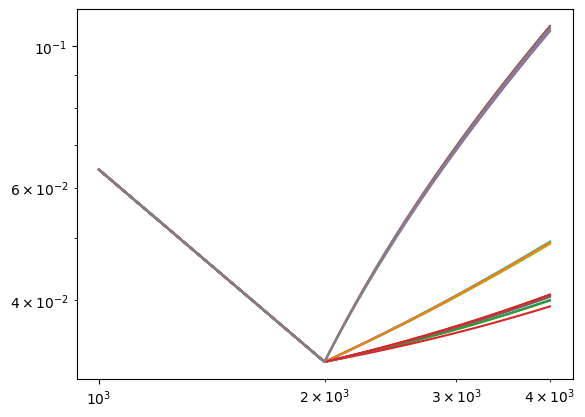

In [9]:
nre = np.linspace(1000, 4000, 1000)
edl = np.array([0.0001, 0.01, 0.1])


smooth = True

for ed in edl:
    fr = npy_fr(nre, ed, 0, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 1, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 2, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 3, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 4, smooth)
    plt.plot(nre, fr)
    fr = npy_fr(nre, ed, 5, smooth)
    plt.plot(nre, fr)

plt.xscale('log')
plt.yscale('log')
plt.show()

Корреляция Беггса Брилла

In [10]:
q = np.linspace(1,300, 10)

In [11]:
diam_m = 0.062
theta = 90
eps_m = 0.00001
Ql_rc_m3day = 40
Qg_rc_m3day = 100
Mul_rc_cP = 0.6
Mug_rc_cP = 3.00E-02
sigma_l_Nm = 2.50E-01
rho_lrc_kgm3 = 600
rho_grc_kgm3 = 20
p_atma = 100

print(npy_Begs_Brill_gradient(diam_m, theta, eps_m, Ql_rc_m3day, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3))


(np.float64(0.03519006583777442), np.float64(0.035091188981492646), np.float64(9.887685628177268e-05), 0, 0.1533461894360575, 0.3833654735901437, np.float64(0.5902733938196266), 3)


In [12]:
bb = np.vectorize(npy_Begs_Brill_gradient)

In [13]:
q = np.linspace(1,500, 100)
g = bb(diam_m, theta, eps_m, q, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3)

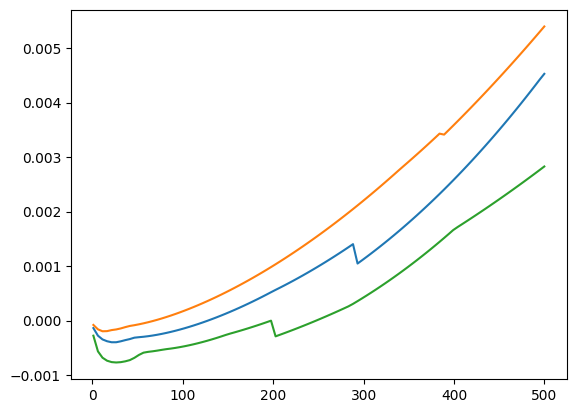

In [14]:
q = np.linspace(1,500, 100)

theta = -1

Qg_rc_m3day = 100
g = bb(diam_m, theta, eps_m, q, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3)
plt.plot(q, g[0])


Qg_rc_m3day = 200
g = bb(diam_m, theta, eps_m, q, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3)
plt.plot(q, g[0])

Qg_rc_m3day = 30
g = bb(diam_m, theta, eps_m, q, Qg_rc_m3day, Mul_rc_cP, Mug_rc_cP, sigma_l_Nm, rho_lrc_kgm3, rho_grc_kgm3)
plt.plot(q, g[0])